<a href="https://colab.research.google.com/github/piyushsharma1812/recurrent-neural-networks/blob/master/NER_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Required Libraries 
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

Using TensorFlow backend.


In [1]:
!pip install  sklearn_crfsuite
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install seqeval 


     |████████████████████████████████| 757kB 13.6MB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-mi5xcnd6
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-mi5xcnd6
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=90fdfa9b1fd8972be383b86960625f08b2bba9a1913857247f61ed20755f5281
  Stored in directory: /tmp/pip-ephem-wheel-cache-irz3z024/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=6253fe759fbe66f2147a61e5b5e090f2d29875419560cfb4f94043ba4f9d980e
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/DataSet/ner_dataset.csv"
df= pd.read_csv(path,encoding = "ISO-8859-1")

In [6]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [7]:
df["Tag"].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [8]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 25771,the,NN,O
freq,1,52573,145807,887908


In [9]:
#Checking null values, if any.
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [0]:
df = df.fillna(method = 'ffill')

In [0]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [12]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [13]:
sentences[2]

'Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .'

In [14]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
# Taking all the sentences
sentences = getter.sentences

In [16]:
sentences[:2]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [0]:
#Defining the parameter of LSTM
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 8
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40

In [0]:
#Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [19]:
print("The word India is identified by the index: {}".format(word_to_index["India"]))
print("The label B-org for the organization is identified by the index: {}".format(tag_to_index["B-org"]))

The word India is identified by the index: 2570
The label B-org for the organization is identified by the index: 6


In [0]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [0]:
# Convert label to index
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [0]:
num_tag = df['Tag'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [23]:
y[0]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [25]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (40765, 75)
Size of training output data :  (40765, 75, 18)
Size of testing input data :  (7194, 75)
Size of testing output data :  (7194, 75, 18)


In [26]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [27]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[2] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [27]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 10.2MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
df.head()
num_tags = df['Tag'].nunique()

In [29]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 1,449,928
Trainable params: 1,449,928
Non-trai

In [0]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')


In [31]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])




Train on 36688 samples, validate on 4077 samples
Epoch 1/8





36688/36688 [==============================] - 240s 7ms/step - loss: 9.1598 - crf_viterbi_accuracy: 0.8922 - val_loss: 8.8530 - val_crf_viterbi_accuracy: 0.9503
Epoch 2/8
36688/36688 [==============================] - 233s 6ms/step - loss: 8.8847 - crf_viterbi_accuracy: 0.9600 - val_loss: 8.7934 - val_crf_viterbi_accuracy: 0.9647
Epoch 3/8
36688/36688 [==============================] - 230s 6ms/step - loss: 8.8488 - crf_viterbi_accuracy: 0.9688 - val_loss: 8.7828 - val_crf_viterbi_accuracy: 0.9646
Epoch 4/8
36688/36688 [==============================] - 229s 6ms/step - loss: 8.8348 - crf_viterbi_accuracy: 0.9721 - val_loss: 8.7725 - val_crf_viterbi_accuracy: 0.9686
Epoch 5/8
36688/36688 [==============================] - 227s 6ms/step - loss: 8.8265 - crf_viterbi_accuracy: 0.9744 - val_loss: 8.7697 - val_crf_viterbi_accuracy: 0.9688
Epoch 6/8
36688/36688 [==============================] - 226s 6ms/step - loss: 8.8210 - 

In [32]:
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

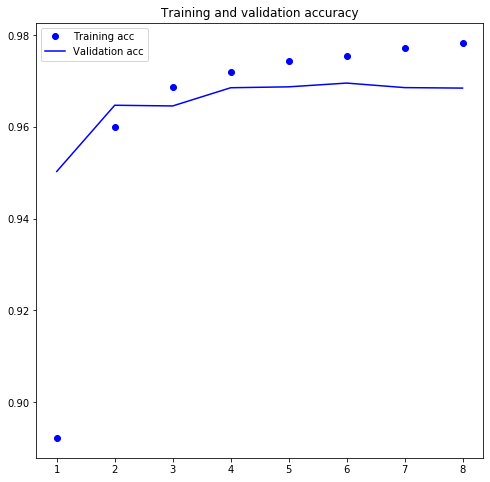

In [33]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

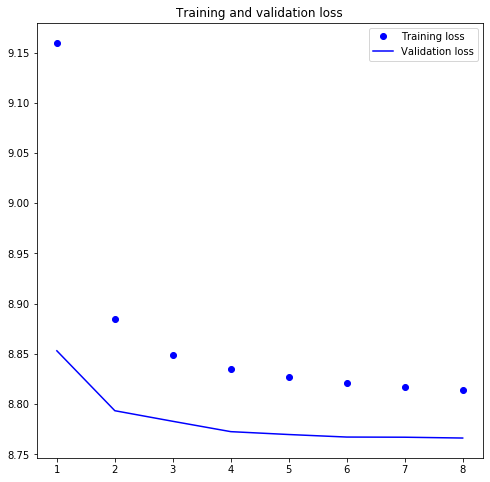

In [34]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

['O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

please use 
keras==2.2.4 

In [0]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [0]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [38]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 88.0%


In [39]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        56
       B-eve       0.50      0.24      0.32        38
       B-geo       0.88      0.88      0.88      5700
       B-gpe       0.96      0.94      0.95      2352
       B-nat       0.91      0.31      0.47        32
       B-org       0.73      0.74      0.74      3038
       B-per       0.83      0.82      0.82      2488
       B-tim       0.90      0.89      0.89      3017
       I-art       0.00      0.00      0.00        35
       I-eve       0.00      0.00      0.00        33
       I-geo       0.81      0.79      0.80      1127
       I-gpe       0.90      0.60      0.72        30
       I-nat       1.00      0.29      0.44         7
       I-org       0.71      0.82      0.76      2479
       I-per       0.86      0.83      0.84      2553
       I-tim       0.81      0.76      0.79      1011
           O       0.99      0.99      0.99    131646
         PAD       1.00    

In [0]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 5331 of 7194 (Test Set)
Word           ||True ||Pred
In             : O     O
a              : O     O
separate       : O     O
statement      : O     O
,              : O     O
the            : O     O
Muslim         : B-org B-org
Public         : I-org I-org
Affairs        : I-org I-org
Council        : I-org I-org
extended       : O     O
condolences    : O     O
to             : O     O
the            : O     O
families       : O     O
of             : O     O
the            : O     O
victims        : O     O
and            : O     O
to             : O     O
the            : O     O
British        : B-gpe B-gpe
people         : O     O
.              : O     O


In [0]:
with open('word_to_index.pickle', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag_to_index, f)